## Diffusion Same-Sample Optimictic Gradient (DSS-OG)
1. A sample code for implementing DSS-OG. The code can be further optimized and parallelized.  <br />
2. A portion of the code was adapted from  https://github.com/aorvieto/NCPL/tree/main. In this project, a similar training fashion was carried out at each single node level. <br />
3. To ensure same dataset for all algorithms and avoid the impact of randomness, we set the same random seed before running each algorithm over the simulations.

Author: Haoyuan, Cai || EPFL, ASL || Date: Nov, 2023


In [1]:
import torch
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import pandas as pd
from my_optimizers import *
from topology import *
%config InlineBackend.figure_format = 'svg'
from torch.utils.data import Dataset, DataLoader
plt.rcParams.update({'font.size': 15})
from collections import OrderedDict
import random
import math
import copy

/home/hcai/hcai/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Parameter

In [2]:
device = "cpu" # run on cpu
nit = 1000    # number of iterations
bs = 100       # batch size
epoch = 1      # number of simulation trial
real_mu = 0    # true mean 
#real_sigma = 0.1 # first experiment 
real_sigma = 0.001 # second experiment 
penalty = 0.001    # penalty factor
seeds = 0   
np.random.seed(seeds)
torch.manual_seed(seeds)

### Network topology

In [3]:
def generate_graph(K,method,pro):
    '''
    Generate connected network
    ''' 
    degree = np.zeros((K,K)) # degree matrix 
    adjacency = np.zeros((K,K)) # adjacency matrix 
    eigenvalue = 0
    while eigenvalue < 1e-4:
        A  =  generate_network(K, method, plot= False, prob = pro)
        adjacency[A[0]>0] = 1
        for k in range(K):
            adjacency[k,k] = 0
            degree[k,k] = sum(adjacency[k])
        Laplacian = degree - adjacency
        W,D,h = np.linalg.svd(Laplacian)
        eigenvalue = D[-2]
        print("eigenvalue of Laplacian is:", eigenvalue)
    return A

In [4]:
N_agent = 4       # number of agents
prob = 0.7        # connectivity probability
method = 'average_rule'  # network topology
A = generate_graph(N_agent,method,prob)[0]  # left stochastic network topology
A_cent = np.ones((N_agent, N_agent))/N_agent # network topology with a coordinator
print(A_cent)
print(A)

eigenvalue of Laplacian is: 2.0
[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
[[0.33333333 0.         0.25       0.25      ]
 [0.         0.33333333 0.25       0.25      ]
 [0.33333333 0.33333333 0.25       0.25      ]
 [0.33333333 0.33333333 0.25       0.25      ]]


### Neural Nets

In [5]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()   # layer1 -> layer2 -> output
        self.fc1 = torch.nn.Linear(1, 5)    # 
        self.fc2 = torch.nn.Linear(5, 1)    # 

    def forward(self, x):
        out1 = F.relu(self.fc1(x))
        out2 = self.fc2(out1)
        return out2
    
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.theta1 = nn.Parameter(torch.zeros(1).uniform_(-1,1))
        self.theta2 = nn.Parameter(torch.zeros(1).uniform_(-1,1))
        
    def forward(self, x):
        return self.theta1*x+self.theta2*x*x

### Diffusion Model

In [6]:
def ATC_diffusion(model_comb, A):
    '''
    This function performs adapt-then-combine diffusion learning strategy

    param model_comb:  list of neural network model
    param A: combination matrix
    param device: gpu or cpu

    return:  True
    '''
    with torch.no_grad():
        ##combine the parameters of all agents
        net_comb_state_dict_temp = [net.state_dict() for net in model_comb]
        net_comb_state_dict = copy.deepcopy(net_comb_state_dict_temp)

        weight_keys = list(net_comb_state_dict[0].keys())
        K = len(A[0])
        for j in range(K):
            updated_state_dict = OrderedDict()  # construct a dictionary
            for key in weight_keys:
                key_sum = 0
                for n in range(len(net_comb_state_dict)):
                    key_sum = key_sum + A[n][j] * net_comb_state_dict[n][key]
                updated_state_dict[key] = key_sum
            model_comb[j].load_state_dict(updated_state_dict)

    return True

### Training Functions


In [25]:
def train(settings):
    
    grad_x = torch.zeros((nit,epoch), requires_grad=False)    # gradient norm
    grad_y = torch.zeros((nit,epoch), requires_grad=False)    # gradient norm
    grad_xy = torch.zeros((nit,epoch), requires_grad=False)   # sum of gradient norm
    loss_hist = torch.zeros((nit,epoch), requires_grad=False) # loss value

    for e in range(epoch):
        
        #-------------------------------------------------------------------------------------------------
        # Init Neural Models List
        #-------------------------------------------------------------------------------------------------
        Nets_G = [Generator().to(device) for i in range(N_agent)] # create instance for each agent
        Nets_D = [Discriminator().to(device) for i in range(N_agent)] 
        #=================================================================================================


        #-------------------------------------------------------------------------------------------------
        # Init Optimizer List
        #-------------------------------------------------------------------------------------------------
        optimizer_G = []
        optimizer_D = []
        for n in range(N_agent):
            if  settings["optim"] == "DSS_OG" or settings["optim"] == "CSS_OG":
                tau_1 = settings["tau1"]
                tau_2 = settings["tau2"]
                gamma_1 = settings["gamma1"]
                gamma_2 = settings["gamma2"]
                optimizer_G.append(SS_OG(Nets_G[n].parameters(), lr=tau_1, gamma = gamma_1))
                optimizer_D.append(SS_OG(Nets_D[n].parameters(), lr=tau_2, gamma = gamma_2))
                name = r""+settings["optim"]+', $\\tau_1 = '+str(settings["tau1"])+', \\tau_2 = '+str(settings["tau2"])+', \\gamma_1 = '+str(settings["gamma1"])+',\\gamma_2 ='+str(settings["gamma2"])+'$'
               
            elif settings["optim"] == 'Adam':
                tau=settings["tau"]
                beta1_s = settings["beta1"]
                beta2_s = settings["beta2"]
                optimizer_G.append(Adam(Nets_G[n].parameters(), lr=tau, betas=(beta1_s, beta2_s), eps = 1e-8))
                optimizer_D.append(Adam(Nets_D[n].parameters(), lr=tau, betas=(beta1_s, beta2_s), eps = 1e-8))
                name = r""+settings["optim"]+', $\\tau = '+str(settings["tau"])+', \\beta_1 = '+str(settings["beta1"])+', \\beta_2 = '+str(settings["beta2"])+'$'
        
            elif settings["optim"] == 'RMSprop':
                tau=settings["tau"]
                beta1_s = 0
                beta2_s = settings["beta2"]
                optimizer_G.append(Adam(Nets_G[n].parameters(), lr=tau, betas=(beta1_s, beta2_s), eps = 1e-8))
                optimizer_D.append(Adam(Nets_D[n].parameters(), lr=tau, betas=(beta1_s, beta2_s), eps = 1e-8))
                name = r""+settings["optim"]+', $\\tau = '+str(settings["tau"])+', \\beta_2 = '+str(settings["beta2"])+'$'

            elif settings["optim"] == 'SAGDA':
                tau_1=settings["tau1"]
                tau_2=settings["tau2"]
                optimizer_G.append(GD(Nets_G[n].parameters(), lr=tau_1))
                optimizer_D.append(GD(Nets_D[n].parameters(), lr=tau_2))
                name = r""+settings["optim"]+', $\\tau_1 = '+str(settings["tau1"])+', \\tau_2 = '+str(settings["tau2"])+'$'

            elif settings["optim"] == 'Smooth-SAGDA':
                tau_1 = settings["tau1"]
                tau_2 = settings["tau2"]
                beta_s = settings["beta"]
                P_s = settings["P"] 
                optimizer_G.append(Cata(Nets_G[n].parameters(), lr=tau_1, beta = beta_s, P = P_s))
                optimizer_D.append(GD(Nets_D[n].parameters(), lr=tau_2))
                name = r""+settings["optim"]+', $\\tau_1 = '+str(settings["tau1"])+', \\tau_2 = '+str(settings["tau2"])+', \\beta = '+str(settings["beta"])+', P = '+str(settings["P"])+'$'
            else:
                raise ValueError('Optimizer not defined')
        #===================================================================================================================================================================   
        A = A_cent
        AA = A_cent if settings["optim"] == "CSS_OG" else A 
        print(AA)
        ATC_diffusion(Nets_G, AA)
        ATC_diffusion(Nets_D, AA)
        
        # for idx in range(N_agent):
        #     Nets_G[idx].load_state_dict(Nets_G[0].cpu().state_dict())
        #     Nets_D[idx].load_state_dict(Nets_D[0].cpu().state_dict())

        #---------------------------------------------------------------------------------------------------------------------------------------------------
        # Init buffer for CSS-OG and DSS-OG
        #---------------------------------------------------------------------------------------------------------------------------------------------------
        if settings["optim"] == "CSS_OG" or settings["optim"] == "DSS_OG": 
            for n in range(N_agent):
                optimizer_D[n].init_buff()
                optimizer_G[n].init_buff()
        #=====================================================================================================================================================
                 
        # ---------------------------------------------------------------------------------------------------------------------------------------------------
        # Training start
        # ---------------------------------------------------------------------------------------------------------------------------------------------------
        for i in range(nit):
            for n in range(N_agent):

                #------------------------Get a batch of samples-------------------------------------
                z_D = torch.zeros(bs).normal_(0,1).reshape(-1,1)
                real = real_mu+ real_sigma*z_D
                #-----------------------------------------------------------------------------------

                #========Discriminator Update========================================================   　
                if settings["optim"] == "DSS_DG" or settings["optim"] == "CSS_OG":                  
                    fake = Nets_G[n](z_D)
                    critic_real = Nets_D[n](real).reshape(-1)
                    critic_fake = Nets_D[n](fake).reshape(-1)
                    loss_critic = -torch.mean(critic_real) + torch.mean(critic_fake)+penalty*(Nets_D[n].theta1**2+Nets_D[n].theta2**2)
                    optimizer_D[n].zero_grad()
                    loss_critic.backward(retain_graph=True)
                    
                    # set the discriminator and generator to previous diffusion state
                    optimizer_D[n].forward_step()  
                    optimizer_G[n].set_model('previous_diffusion') 

                    # compute backward gradient using the same samples
                    fake = Nets_G[n](z_D)        
                    critic_real = Nets_D[n](real).reshape(-1)
                    critic_fake = Nets_D[n](fake).reshape(-1)
                    optimizer_G[n].set_model('current_diffusion')
                    loss_critic = -torch.mean(critic_real) + torch.mean(critic_fake)+penalty*(Nets_D[n].theta1**2+Nets_D[n].theta2**2)
                    optimizer_D[n].zero_grad()
                    loss_critic.backward()
                    # model update
                    optimizer_D[n].step()
                    
                else: # other methods perform:
                    fake = Nets_G[n](z_D)           
                    critic_real = Nets_D[n](real).reshape(-1)
                    critic_fake = Nets_D[n](fake).reshape(-1)
                    loss_critic = -torch.mean(critic_real) + torch.mean(critic_fake)+penalty*(Nets_D[n].theta1**2+Nets_D[n].theta2**2)            
                    optimizer_D[n].zero_grad()
                    loss_critic.backward()        
                    optimizer_D[n].step()            
                #==================================================================================================
                
                #================Generator Update==================================================================
                if settings["optim"] == "DSS_OG" or settings["optim"] == "CSS_OG":
                    gen_fake = Nets_D[n](Nets_G[n](z_D)).reshape(-1)
                    optimizer_G[n].zero_grad()
                    loss_gen = -torch.mean(gen_fake)
                    loss_gen.backward(retain_graph =True)

                    # set the discriminator and generator to old state
                    optimizer_G[n].forward_step() 
                    optimizer_D[n].set_model('current_diffusion')   

                    # compute the backward gradient using the same samples 
                    gen_fake = Nets_D[n](Nets_G[n](z_D)).reshape(-1)  
                    optimizer_D[n].set_model('current') # set to current state of discriminator, i.e., \phi
                    loss_gen = -torch.mean(gen_fake)
                    optimizer_G[n].zero_grad()  
                    loss_gen.backward()

                    # model update
                    optimizer_G[n].step()
                    
                else:
                    gen_fake = Nets_D[n](Nets_G[n](z_D).reshape(-1))
                    optimizer_G[n].zero_grad()
                    loss_gen = -torch.mean(gen_fake)
                    loss_gen.backward()
                    optimizer_G[n].step()
                #===============================================================================================

                
                #=====save results==========================================================================
                with torch.no_grad():
                    grad_x[i,e] += optimizer_D[n].get_gradient_norm().cpu().detach() 
                    grad_y[i,e] += optimizer_G[n].get_gradient_norm().cpu().detach()   
                    grad_xy[i, e] +=  optimizer_D[n].get_gradient_norm().cpu().detach() + optimizer_G[n].get_gradient_norm().cpu().detach() 
                    gen_gake =  Nets_G[n](z_D)
                    est_mu = torch.mean(gen_gake)
                    est_sigma = torch.std(gen_gake)
                    loss_hist[i,e] += torch.abs(est_mu-real_mu)**2+torch.abs(torch.abs(est_sigma)-real_sigma)**2
                #================================================================================================

            grad_x[i,e]/= N_agent
            grad_y[i,e]/= N_agent
            grad_xy[i,e]/= N_agent
            loss_hist[i,e]/= N_agent

            if i%100 == 0:
                print(f'Epoch: {e}, Iteration {i},  Gradient norm: {grad_xy[i,e]}, MSD: {loss_hist[i,e]}')

            # model diffusion and buffer shift
            if settings["optim"] == "CSS_OG" or settings["optim"] == "DSS_OG":
                for n in range(N_agent):
                    optimizer_D[n].set_buff('shift')
                    optimizer_G[n].set_buff('shift')
                AA = A_cent if settings["optim"] == "CSS_OG" else A
                ATC_diffusion(Nets_G, AA)
                ATC_diffusion(Nets_D, AA)
                for n in range(N_agent):
                    optimizer_D[n].set_buff('current_diffusion')
                    optimizer_G[n].set_buff('current_diffusion')
            else:
                ATC_diffusion(Nets_G, A)
                ATC_diffusion(Nets_D, A)


    return [settings["optim"],loss_hist,grad_x,grad_y, grad_xy]

### Main function

In [8]:
print(A)

[[0.33333333 0.         0.25       0.25      ]
 [0.         0.33333333 0.25       0.25      ]
 [0.33333333 0.33333333 0.25       0.25      ]
 [0.33333333 0.33333333 0.25       0.25      ]]


In [26]:
seeds = 0

Algs_list=[]
#Algs_list.append({"optim":"RMSprop", "tau": 1e-3, "beta2": 0.9 })
#Algs_list.append({"optim":"SAGDA", "tau1": 1e-1, "tau2": 5e-1})
#Algs_list.append({"optim":"Smooth-SAGDA", "tau1": 1e-1, "tau2": 1e-1, "beta":0.5, "P":10})
#Algs_list.append({"optim":"Adam", "tau": 1e-3, "beta1": 0.5, "beta2": 0.9 })
#Algs_list.append({"optim": "DSS_OG", "tau1":0.01, "tau2":0.01, "gamma1":1.0, "gamma2":1.0})
#Algs_list.append({"optim": "CSS_OG", "tau1":0.1, "tau2":0.1, "gamma1":1.0, "gamma2":1.0})
Algs_list.append({"optim": "DSS_OG", "tau1":0.1, "tau2":0.1, "gamma1":1.0, "gamma2":1.0})

gx = []
gy = []
gxy = []
names = []
loss = []

for i in range(len(Algs_list)):
    print(Algs_list[i]["optim"])
    np.random.seed(seeds)   #  the same random seed
    torch.manual_seed(seeds) 
    names_c,loss_c, gx_c, gy_c, gxy_c= train(Algs_list[i])
    names.append(names_c)
    loss.append(loss_c)
    gx.append(gx_c)
    gy.append(gy_c)
    gxy.append(gxy_c)
print('Simulation finish!')

DSS_OG
[[0.33333333 0.         0.25       0.25      ]
 [0.         0.33333333 0.25       0.25      ]
 [0.33333333 0.33333333 0.25       0.25      ]
 [0.33333333 0.33333333 0.25       0.25      ]]
Epoch: 0, Iteration 0,  Gradient norm: 0.12607721984386444, MSD: 0.014289434999227524
[[0.33333333 0.         0.25       0.25      ]
 [0.         0.33333333 0.25       0.25      ]
 [0.33333333 0.33333333 0.25       0.25      ]
 [0.33333333 0.33333333 0.25       0.25      ]]
Epoch: 0, Iteration 100,  Gradient norm: nan, MSD: nan
[[0.33333333 0.         0.25       0.25      ]
 [0.         0.33333333 0.25       0.25      ]
 [0.33333333 0.33333333 0.25       0.25      ]
 [0.33333333 0.33333333 0.25       0.25      ]]
Epoch: 0, Iteration 200,  Gradient norm: nan, MSD: nan
[[0.33333333 0.         0.25       0.25      ]
 [0.         0.33333333 0.25       0.25      ]
 [0.33333333 0.33333333 0.25       0.25      ]
 [0.33333333 0.33333333 0.25       0.25      ]]
Epoch: 0, Iteration 300,  Gradient norm: 

KeyboardInterrupt: 

### Save data

In [10]:
import os 
import pickle
name_exp = 'toy_wgan_012024'
results_PATH = os.path.join('./results', name_exp)
os.makedirs(results_PATH, exist_ok=True)
pickle.dump(gxy, open(os.path.join(results_PATH, 'grad_norm_case0001.pkl'), 'wb'))
pickle.dump(loss, open(os.path.join(results_PATH, 'grad_mse_case0001.pkl'), 'wb'))

### Plotting function

10000


/home/hcai/hcai/lib/python3.9/site-packages/numpy/core/_methods.py:236: RuntimeWarning:

invalid value encountered in subtract



10000
10000


<function matplotlib.pyplot.show(close=None, block=None)>

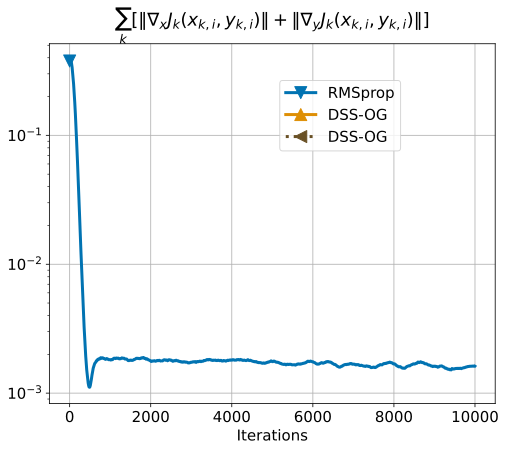

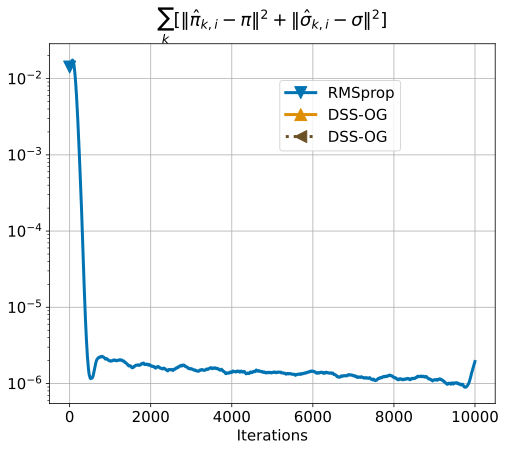

In [11]:
import os 
import pickle

name_exp = 'toy_wgan_012024'
results_PATH = os.path.join('./results', name_exp)
with open(os.path.join(results_PATH, 'grad_norm_case0001.pkl'), 'rb') as file:
    gxy = pickle.load(file)

with open(os.path.join(results_PATH, 'grad_mse_case0001.pkl'), 'rb') as file:
    loss = pickle.load(file)

scale = 0.4
plt.rcParams["figure.figsize"] = (8, 6.5)   # figure size

#names  = ['RMSprop','SAGDA', 'Smooth-SAGDA', 'Adam', 'DSS-OG','CSS-OG']
names  = ['RMSprop','DSS-OG', 'DSS-OG']
markers = ["v","^","<",">","o","s","p","P","*"]
colors = sns.color_palette('colorblind')
Algs_list = names
for i in range(len(Algs_list)):
    # mean_x_log = np.mean(np.log10(gx[i].detach().numpy()),1)
    # std_x_log = np.std(np.log10(gx[i].detach().numpy()), 1)
    # mean_y_log = np.mean(np.log10(gy[i].detach().numpy()),1)
    # std_y_log = np.std(np.log10(gy[i].detach().numpy()), 1)
    mean_xy_log = np.mean(np.log10(gxy[i].detach().numpy()),1)
    std_xy_log = np.std(np.log10(gxy[i].detach().numpy()), 1)
    mean_msd_log = np.mean(np.log10(loss[i].detach().numpy()),1)
    std_msd_log = np.std(np.log10(loss[i].detach().numpy()), 1)
    # mean_x_log_s = savgol_filter(mean_x_log, 601, 3, mode='nearest')
    # mean_y_log_s = savgol_filter(mean_y_log, 601, 3, mode='nearest')
    mean_xy_log_s = savgol_filter(mean_xy_log, 601, 3, mode='nearest')
    mean_msd_log_s = savgol_filter(mean_msd_log, 601, 3, mode='nearest')

    # std_x_log_s = savgol_filter(std_x_log, 601, 3, mode='nearest')
    # std_y_log_s = savgol_filter(std_y_log, 601, 3, mode='nearest')
    std_xy_log_s = savgol_filter(std_xy_log, 601, 3, mode='nearest')
    std_msd_log_s = savgol_filter(std_msd_log, 601, 3, mode='nearest')

    if i==(len(Algs_list)-1):
        cc='#695025'
        ls='dotted'
    else:
        cc = colors[i%10]
        ls='-'

    ## Plotting grad_x
    # ax = plt.plot(1)
    # plt.plot(range(nit),np.power(10,mean_x_log_s), linestyle=ls, marker = markers[i%7], label=names[i],linewidth=3, color = cc, markevery=10000, markersize = 12)
    # plt.fill_between(range(nit),np.power(10,mean_x_log_s-scale*std_x_log_s) , np.power(10,mean_x_log_s+scale*std_x_log_s), alpha=0.5, fc=cc)
    # plt.xlabel("Iterations")
    # plt.title(r'$\Vert\nabla_x F(x,y)\Vert$')
    # plt.yscale("log")
    # plt.grid()

    ## Plotting grad_y
    # ax = plt.plot(2)
    # plt.plot(range(nit),np.power(10,mean_y_log_s), linestyle=ls, marker = markers[i%7], label=names[i],linewidth=3,color =  cc, markevery=10000, markersize = 12)
    # plt.fill_between(range(nit),np.power(10,mean_y_log_s-scale*std_y_log_s) , np.power(10,mean_y_log_s+scale*std_y_log_s), alpha=0.5, fc= cc)
    # plt.xlabel("Iterations")
    # plt.title(r'$\Vert\nabla_y F(x,y)\Vert$')
    # plt.yscale("log")
    # plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
    # plt.grid()
    a = np.power(10,mean_xy_log_s)
    print(len(a))
    marker = markers[i%7]
    label=names[i]
    ## Plotting grad_xy
    ax = plt.figure(1)
    plt.plot(range(nit),np.power(10,mean_xy_log_s), linestyle=ls, marker = markers[i%7], label=names[i],linewidth=3,color =  cc, markevery=10000, markersize = 12)

    
    plt.fill_between(range(nit),np.power(10,mean_xy_log_s-scale*std_xy_log_s) , np.power(10,mean_xy_log_s+scale*std_xy_log_s), alpha=0.5, fc= cc)
    plt.xlabel("Iterations")
    plt.title(r'$\sum_{k}[\Vert\nabla_x J_k(x_{k,i},y_{k,i})\Vert+\Vert\nabla_y J_k(x_{k,i},y_{k,i})\Vert]$')
    plt.yscale("log")
    plt.legend(loc='center left', bbox_to_anchor=(0.5,0.8))
    plt.grid()
    plt.savefig('example1_variance00001_grad.pdf')

    ## Plot msd
    ax = plt.figure(2)
    plt.plot(range(nit),np.power(10,mean_msd_log_s), linestyle=ls, marker = markers[i%7], label=names[i],linewidth=3,color =  cc, markevery=10000+i*1000, markersize = 12)
    plt.fill_between(range(nit),np.power(10,mean_msd_log_s-scale*std_msd_log_s) , np.power(10,mean_msd_log_s+scale*std_msd_log_s), alpha=0.5, fc= cc)
    plt.xlabel("Iterations")
    plt.title(r'$\sum_{k}[\Vert\hat{\pi}_{k,i} - \pi\Vert^2+\Vert\hat{\sigma}_{k,i} - \sigma\Vert^2]$')
    plt.yscale("log")
    plt.legend(loc='center left', bbox_to_anchor=(0.5, 0.8))
    plt.grid()
    plt.savefig('example1_variance00001_mse.pdf')

plt.show





In [43]:
print(os.getcwd())

/home/hcai/phd/minimax/112023NCPL_TAC
